### In this file:
- create true data for with and no planet 
- fit the no planet data using the matrix method 
- fit the planet data using least squares 

In [1]:
# importing packages, functions, etc 
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from numpy import cos, sin
from scipy.linalg import lstsq
from scipy.optimize import leastsq
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100

from functions_new_parameters import cov_func
from functions_new_parameters import generate_parallax_signal
from functions_new_parameters import signal_func_np
from functions_new_parameters import signal_func
from functions_new_parameters import normalized_residuals
from functions_new_parameters import calculate_a_hat
from functions_new_parameters import find_chi_squared
from functions_new_parameters import find_var_from_param

from error_var_fitting import big_func

In [2]:
# initial inputs 
np.random.seed(5) 

N = 100 # number of timesteps 
S = 50  # number of samples 

times = np.linspace(0, 4.2, N)
theta = np.linspace(0, 2*np.pi, N)

alpha0, delta0 = 1, 0.3

truepars = np.array((0,                      # alpha                                     [rad]
                     0,                      # delta                                     [rad]
                     2.3084641853871365e-07, # proper motion in RA direction  (mu alpha) [rad/year]
                     1.770935480191023e-07,  # proper motion in Dec direction (mu delta) [rad/year]
                     9.699321049402031e-08,  # parallax                                  [rad]
                     0.5348901624946122,     # var1: sqrt(cosi)cos(Omega)                [unitless]
                     0.8330420709110249,     # var2: sqrt(cosi)sin(Omega)                [unitless]
                     -0.18610652302818084,   # var3: sqrt(e)cos(omega)                   [unitless]
                     0.406650171629573,      # var4: sqrt(e)sin(omega)                   [unitless]
                     0.0143188,              # mass of planet                            [solar masses]
                     0.46146592515998475 ,   # orbital period                            [years]
                     0.0))                   # time of pericentre passage                [years]

sigma_err = (1e-5*np.pi/180/60/60)*10           # [rad]

### Setting true parameters arrays for with and without planet 

In [3]:
# setting the true parameters with no planet 

np_truepars_array = np.zeros((S, 5))

np_truepars_array[:,0] = np.random.normal(0, 1.93925472e-10, S)    # Delta_alpha_0
np_truepars_array[:,1] = np.random.normal(0, 1.93925472e-10, S)    # Delta_delta_0
np_truepars_array[:,2] = truepars[2]                               # mu_alpha
np_truepars_array[:,3] = truepars[3]                               # mu_delta
np_truepars_array[:,4] = truepars[4]                               # varpi

In [4]:
# setting extra parameters needed to find true parameters for with planet 

extra_params = np.zeros((S, 4))

extra_params[:,0] = np.random.uniform(0, 0.5, S)      # e
extra_params[:,1] = np.random.uniform(0, 2*np.pi, S)  # omega
extra_params[:,2] = np.random.uniform(0, 2*np.pi, S)  # Omega
extra_params[:,3] = np.random.uniform(0, 1, S)        # cos i 

In [5]:
# setting true parameters for with planet 

wp_truepars_array = np.ones((S, 12))

wp_truepars_array[:,0]  = np.random.normal(0, 1.93925472e-10, S)            # Delta_alpha_0
wp_truepars_array[:,1]  = np.random.normal(0, 1.93925472e-10, S)            # Delta_delta_0
wp_truepars_array[:,2]  = truepars[2]                                       # mu_alpha
wp_truepars_array[:,3]  = truepars[3]                                       # mu_delta 
wp_truepars_array[:,4]  = truepars[4]                                       # varpi 
wp_truepars_array[:,9]  = truepars[9]                                       # m_planet 
wp_truepars_array[:,10] = truepars[10]                                      # P_orb 
wp_truepars_array[:,11] = np.random.uniform(0, wp_truepars_array[:,10], S)  # t_peri

for i in range(S):
    wp_truepars_array[i,5], wp_truepars_array[i,6], wp_truepars_array[i,7], wp_truepars_array[i,8] = find_var_from_param(extra_params[i,0], extra_params[i,1], extra_params[i,2], extra_params[i,3]) # var1, var2, var3, var4

# Testing function 

In [25]:
a_hat_func, sigma_err_array_func, Delta_BIC_func = big_func(N, S, times, theta, alpha0, delta0, truepars, wp_truepars_array)

/Users/audreyburggraf/Desktop/CITA/CTA200H/PROJECT/functions_new_parameters.py:36: RuntimeWarning: invalid value encountered in sqrt
  sin_i = np.sqrt(1-cos_i**2)
/Users/audreyburggraf/Desktop/CITA/CTA200H/PROJECT/functions_new_parameters.py:94: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt((1-e**2))*sin(E)


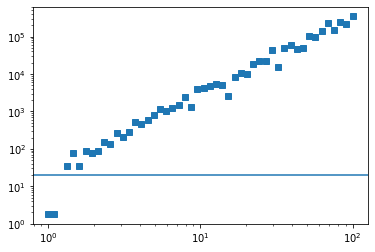

In [26]:
plt.plot(a_hat_func/sigma_err_array_func, -1*Delta_BIC_func,'s')
plt.xscale('log')
plt.yscale('log')
plt.axhline(20)

### Setting some values that are the same for both arrays or that need to be set above 

In [7]:
# setting a_hat 
a_hat = calculate_a_hat(truepars[4], truepars[9], truepars[10])

Text(0.5, 0, '$\\sigma$')

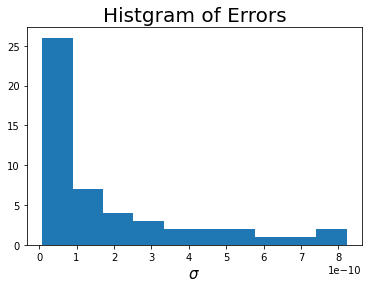

In [8]:
# setting sigma (error)
sigma_err_array = np.geomspace(0.01, 1, S)*a_hat

plt.hist(sigma_err_array)
plt.title('Histgram of Errors', fontsize = 20)
plt.xlabel('$\sigma$', fontsize = 15)

In [9]:
# setting noise used to create observed data from true data 

noise = np.zeros((S,N))

for i in range(S):
    noise[i] = np.random.normal(0, sigma_err_array[i], N)

In [10]:
# true and observed data 

wp_eta_true_array = np.zeros((S, N))
wp_eta_obs_array = np.zeros((S, N))

for i in range(S):
    # finding true signal with and without planet 
    _, _ , wp_eta_true_array[i] = signal_func(wp_truepars_array[i], alpha0, delta0, times, theta) 
    
    # observed data is true data plus some noise 
    wp_eta_obs_array[i] = wp_eta_true_array[i] + noise[i]

# No planet: Matrix method 

In [11]:
# creating matrix M
# same for all samples since it only depends on theta, times, alpha0 and delta0 

PI_ra, PI_dec = generate_parallax_signal(alpha0, delta0, 1, times)

M = np.zeros((N, 5))

for i in range(N):
    M[i,0] = cos(theta[i])
    M[i,1] = sin(theta[i])
    M[i,2] = cos(theta[i]) * times[i]
    M[i,3] = sin(theta[i]) * times[i]
    M[i,4] = cos(theta[i])*PI_ra[i] + sin(theta[i])*PI_dec[i]
    
# np_cov[i] = cov_func(M, sigma_err_array[i], print_cov=False)

In [12]:
# finding the best fit values for the S samples 
np_best_fit_val_array = np.zeros((S, 5))

for i in range(S):
    np_best_fit_val_array[i], _, _, _ = lstsq(M, wp_eta_obs_array[i])

In [13]:
array = np.zeros((N, 5))

np_chi_sq_array = np.zeros((S))

for k in range(S):
    x = np_best_fit_val_array[k] # x is equal to the kth row of np_best_fit_val_array
    for i in range(N):
        for j in range(5):
            array[i,j] = M[i,j]*x[j]

    array_row_sums = np.sum(array, axis=1)   
    np_chi_sq_array[k] = np.sum((array_row_sums - wp_eta_obs_array[k])**2/sigma_err_array[k]**2)

# With planet method 

### Creating data where $\sigma$ changes 

In [14]:
guess_array = np.zeros((S,12))

wp_best_fit_val_array = np.zeros((S, 12))

wp_eta_best_array = np.zeros((S, N))

SN = np.zeros((S))

wp_chi_sq_array = np.zeros((S))

In [15]:
for i in range(S):
    # guess
    guess_array[i] = wp_truepars_array[i] #* (1 + np.random.uniform(0,0.0001))
    
    # getting best/fitted values 
    wp_best_fit_val_array[i], _, _, _, _ = leastsq(normalized_residuals, guess_array[i], args=(alpha0, delta0, sigma_err_array[i], wp_eta_obs_array[i], times, theta), full_output=1)

    # creating best signal from the best fit 
    _, _, wp_eta_best_array[i] = signal_func(wp_best_fit_val_array[i], alpha0, delta0, times, theta)
    
    # finding S/N for each sample
    SN[i] = a_hat/sigma_err_array[i]
    
    # finding chi squared for with and without planet
    wp_chi_sq_array[i] = find_chi_squared(wp_eta_best_array[i], wp_eta_obs_array[i], sigma_err_array[i])

### Calculating $BIC$ and $\Delta BIC$

In [16]:
np_BIC = np_chi_sq_array + 5 * np.log(N)
np_BIC

array([3.43760466e+05, 2.15932660e+05, 2.43332698e+05, 1.55358724e+05,
       2.29501941e+05, 1.38191545e+05, 9.72723671e+04, 1.04312349e+05,
       4.88924539e+04, 4.76279934e+04, 6.02333108e+04, 4.95311635e+04,
       1.53991480e+04, 4.32295541e+04, 2.27663292e+04, 2.36628919e+04,
       1.85715353e+04, 1.04120162e+04, 1.04462356e+04, 8.10082262e+03,
       2.91190350e+03, 5.14710328e+03, 5.55008567e+03, 4.66864218e+03,
       4.37056139e+03, 4.24566615e+03, 1.59153209e+03, 2.38454971e+03,
       1.70525902e+03, 1.36893629e+03, 1.19920679e+03, 1.31359399e+03,
       9.99542614e+02, 7.62398508e+02, 7.29814168e+02, 6.18582013e+02,
       4.85741671e+02, 2.92288724e+02, 3.73119834e+02, 3.46590466e+02,
       3.38288428e+02, 2.74581262e+02, 2.10426269e+02, 2.15626601e+02,
       1.86772269e+02, 2.33201727e+02, 1.72672265e+02, 1.81887586e+02,
       1.33537635e+02, 1.46889106e+02])

In [17]:
wp_BIC = wp_chi_sq_array + 12*np.log(N)
wp_BIC

array([130.74271682, 133.38893068, 123.54407541, 131.11532181,
       130.07023679, 130.5827232 , 161.23449024, 139.27967193,
       127.10924124, 153.26342084, 136.04833964, 128.17652954,
       141.56323666, 137.02214138, 122.95328214, 152.61721396,
       139.15969489, 149.46240302, 146.67640945, 134.30587928,
       130.0944357 , 131.64665537, 160.17748971, 160.80831557,
       157.94317289, 159.31587012, 169.34668122, 145.96399124,
       152.59503838, 124.60833192, 165.4718321 , 139.21056416,
       140.13011522, 117.13043938, 139.76932376, 126.83189121,
       134.48485499, 153.39805653, 148.94354146, 144.49122902,
       144.07582916, 132.29956662, 158.45266327, 155.8618799 ,
       106.60868061, 140.73448868, 130.34961544, 144.79963757,
       131.88393349, 147.69433376])

In [18]:
wp_chi_sq_array

array([ 75.48067459,  78.12688845,  68.28203318,  75.85327958,
        74.80819456,  75.32068097, 105.972448  ,  84.0176297 ,
        71.84719901,  98.00137861,  80.78629741,  72.9144873 ,
        86.30119442,  81.76009915,  67.6912399 ,  97.35517173,
        83.89765266,  94.20036079,  91.41436721,  79.04383704,
        74.83239347,  76.38461314, 104.91544748, 105.54627334,
       102.68113066, 104.05382789, 114.08463899,  90.70194901,
        97.33299615,  69.34628969, 110.20978987,  83.94852193,
        84.86807299,  61.86839714,  84.50728152,  71.56984898,
        79.22281276,  98.13601429,  93.68149923,  89.22918679,
        88.81378693,  77.03752438, 103.19062104, 100.59983767,
        51.34663838,  85.47244644,  75.0875732 ,  89.53759534,
        76.62189126,  92.43229153])

In [19]:
np_chi_sq_array

array([3.43737440e+05, 2.15909635e+05, 2.43309672e+05, 1.55335698e+05,
       2.29478915e+05, 1.38168519e+05, 9.72493413e+04, 1.04289323e+05,
       4.88694280e+04, 4.76049676e+04, 6.02102849e+04, 4.95081376e+04,
       1.53761222e+04, 4.32065283e+04, 2.27433034e+04, 2.36398661e+04,
       1.85485094e+04, 1.03889904e+04, 1.04232097e+04, 8.07779677e+03,
       2.88887765e+03, 5.12407743e+03, 5.52705982e+03, 4.64561633e+03,
       4.34753554e+03, 4.22264030e+03, 1.56850624e+03, 2.36152386e+03,
       1.68223317e+03, 1.34591044e+03, 1.17618094e+03, 1.29056814e+03,
       9.76516763e+02, 7.39372657e+02, 7.06788317e+02, 5.95556162e+02,
       4.62715820e+02, 2.69262873e+02, 3.50093983e+02, 3.23564615e+02,
       3.15262577e+02, 2.51555411e+02, 1.87400418e+02, 1.92600750e+02,
       1.63746418e+02, 2.10175876e+02, 1.49646414e+02, 1.58861735e+02,
       1.10511784e+02, 1.23863255e+02])

In [21]:
Delta_BIC = wp_BIC - np_BIC
Delta_BIC

array([-3.43629723e+05, -2.15799272e+05, -2.43209154e+05, -1.55227608e+05,
       -2.29371871e+05, -1.38060962e+05, -9.71111326e+04, -1.04173069e+05,
       -4.87653447e+04, -4.74747300e+04, -6.00972624e+04, -4.94029870e+04,
       -1.52575848e+04, -4.30925320e+04, -2.26433759e+04, -2.35102747e+04,
       -1.84323756e+04, -1.02625538e+04, -1.02995592e+04, -7.96651674e+03,
       -2.78180907e+03, -5.01545662e+03, -5.38990818e+03, -4.50783387e+03,
       -4.21261822e+03, -4.08635028e+03, -1.42218541e+03, -2.23858572e+03,
       -1.55266398e+03, -1.24432796e+03, -1.03373496e+03, -1.17438343e+03,
       -8.59412499e+02, -6.45268068e+02, -5.90044845e+02, -4.91750122e+02,
       -3.51256816e+02, -1.38890668e+02, -2.24176293e+02, -2.02099237e+02,
       -1.94212599e+02, -1.42281696e+02, -5.19736053e+01, -5.97647215e+01,
       -8.01635880e+01, -9.24672380e+01, -4.23226498e+01, -3.70879481e+01,
       -1.65370150e+00,  8.05227972e-01])

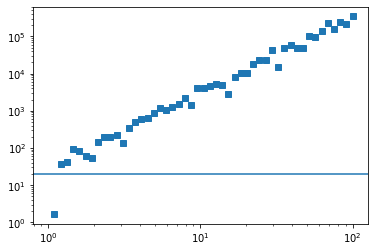

In [22]:
plt.plot(a_hat/sigma_err_array, -1*Delta_BIC,'s')
plt.xscale('log')
plt.yscale('log')
plt.axhline(20)